### 1. Import Dependecies

In [2]:
import os
from enum import Enum
import seaborn as sns
from pydantic import BaseModel
from dotenv import load_dotenv
import numpy as np # alias
import openai, groq
import pandas as pd # alias

load_dotenv()

True

### 2. Basic Information

In [3]:
df = pd.read_csv('data/raw/ChurnModelling.csv')
df.head()

RowNumber  CustomerId Firstname  Lastname  CreditScore Geography  Gender  \
0          1    15634602     Grace  Williams          619    France  Female   
1          2    15647311     David     Jones          608     Spain  Female   
2          3    15619304      Hank  Williams          502    France  Female   
3          4    15701354       Eva    Taylor          699    France  Female   
4          5    15737888     Grace    Miller          850     Spain  Female   

    Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0  42.0       2       0.00              1          1               1   
1  41.0       1   83807.86              1          0               1   
2  42.0       8  159660.80              3          1               0   
3   NaN       1       0.00              2          0               0   
4  43.0       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                600
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

### 3. Handling Missing Values

#### 3.1 Imputation

The possible ways to do this are:

- Filling the missing data with the mean or median value if it’s a numerical variable.
- Filling the missing data with mode if it’s a categorical value.
- Filling the numerical value with 0 or -999, or some other number that will not occur in the data. This can be done so that the machine can recognize that the data is not real or is different.
- Filling the categorical value with a new type for the missing values.

##### 3.2.1 Age

In [9]:
mean = df['Age'].mean()
meadian = df['Age'].median()
mean = round(mean,2)

<Axes: xlabel='Age', ylabel='Count'>

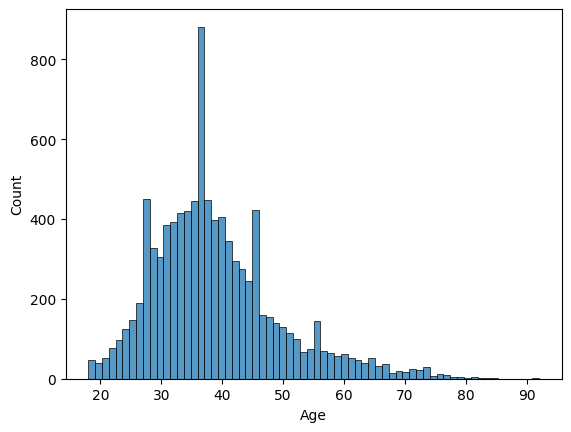

In [10]:
sns.histplot(df['Age'])

In [11]:
df_impute = df.copy()

In [12]:
df_impute.loc[:,'Age'] = df_impute['Age'].fillna(mean)

In [15]:
df_impute.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

##### 3.2.2 Gender

In [21]:
class Gender(Enum):
    MALE = "Male"
    FEMALE = "Female"

class GenderPrediction(BaseModel):
    firstname:str
    lastname:str
    pred_gender:Gender

def predict_gender(
                firstname: str,
                lastname: str
                ):
    prompt = f"""
                What is the most likely gender (Male or Female) for someone with the first name '{firstname}'
                and last name '{lastname}' ?

                Your response only consists of one word: Male or Female
                """
    
    response = groq.Groq().chat.completions.create(
                                                    model="llama-3.3-70b-versatile",
                                                    messages=[{
                                                                "role": "user",
                                                                "content": prompt
                                                            }]
                                                    )
    predicted_gender = response.choices[0].message.content.strip()
    prediction = GenderPrediction(
                                firstname=firstname ,
                                lastname=lastname,
                                pred_gender=predicted_gender
                                )
    return prediction.pred_gender

In [24]:
predict_gender("dinod","Imanjith")

<Gender.MALE: 'Male'>

In [28]:
missing_gender_index = df['Gender'].isnull()
for index in df_impute[missing_gender_index].index:
    firstName = df_impute.loc[index,'Firstname']
    lastName = df_impute.loc[index,'Lastname']
    gender = predict_gender(firstName, lastName)
    
    if gender:
        df_impute.loc[index, 'Gender'] = gender
        print(f"{firstName} {lastName} : {gender}")
    else:
        print(f"{firstName} {lastName} : No Gender Detected")

Eva Wilson : Gender.FEMALE
Ivy Johnson : Gender.FEMALE
David Taylor : Gender.MALE
Frank Davis : Gender.MALE
Jack Wilson : Gender.MALE
David Miller : Gender.MALE
Eva Taylor : Gender.FEMALE
Grace Johnson : Gender.FEMALE
Hank Miller : Gender.MALE
Frank Williams : Gender.MALE
Alice Davis : Gender.FEMALE
Alice Brown : Gender.FEMALE
Alice Garcia : Gender.FEMALE
Bob Jones : Gender.MALE
Jack Davis : Gender.MALE
Grace Williams : Gender.FEMALE
Ivy Jones : Gender.FEMALE
David Smith : Gender.MALE
David Miller : Gender.MALE
Eva Williams : Gender.FEMALE
Frank Garcia : Gender.MALE
Alice Wilson : Gender.FEMALE
Carol Jones : Gender.FEMALE
Hank Davis : Gender.MALE
Ivy Williams : Gender.FEMALE
Hank Smith : Gender.MALE
Ivy Jones : Gender.FEMALE
Alice Brown : Gender.FEMALE
Eva Taylor : Gender.FEMALE
Carol Williams : Gender.FEMALE
Jack Williams : Gender.MALE
Ivy Brown : Gender.FEMALE
David Brown : Gender.MALE
Bob Smith : Gender.MALE
Frank Wilson : Gender.MALE
Bob Williams : Gender.MALE
Ivy Johnson : Gender.

In [38]:
df_impute.isnull().sum()

RowNumber          0
CustomerId         0
Firstname          7
Lastname           6
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [39]:
df_impute= df_impute.drop(
    columns=[
        'RowNumber',
        'CustomerId',
        'Firstname',
        'Lastname'
    ]
)

In [40]:
df_impute.head()

CreditScore Geography  Gender    Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female  42.00       2       0.00              1   
1          608     Spain  Female  41.00       1   83807.86              1   
2          502    France  Female  42.00       8  159660.80              3   
3          699    France  Female  38.91       1       0.00              2   
4          850     Spain  Female  43.00       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [42]:
# saving handled data set
df_impute.to_csv(
                'data/processed/ChurnModelling_Missing_Values_Handled.csv', 
                index=False
                )